In [3]:
!pip install pymysql -q
!pip install plotly -q
!pip install sqlalchemy -q

     |████████████████████████████████| 43 kB 1.9 MB/s 


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import datetime

# 데이터베이스 연결
import sqlalchemy as db
import pymysql

<br>
<br>

#### 데이터베이스 연결 및 테이블 콜 함수

* 유찰물량 데이터: 2019.01.01 ~
* 반입물량 데이터: 2019.01.01 ~
* 유가 데이터: 2016.01.01 ~
* 기상 데이터: 2016.01.01 ~

In [5]:
# floway_user는 SELECT 권한만 가지고 있음
engine = db.create_engine(
    ****',  pool_recycle=500,  pool_pre_ping=True)

metadata = db.MetaData()

In [71]:
# 10월이 '10' 아닌 '1'로 불러지는 문제 => 해결
def select_customs(f_type_nm, page):

    sql = """
    SELECT date_format(CONCAT(yr, '-', mont, '-', '01'), '%Y-%m-%d'),
        statKor,
        impWgt
    FROM (
        SELECT
              SUBSTR(YEAR, 1,4) AS yr,
              CASE
                  WHEN SUBSTR(YEAR, 6,2) = '1' THEN 10
                  ELSE SUBSTR(YEAR, 6,2)
              END AS mont,
              statKor,
              impWgt
        FROM customs
        WHERE statKor = '{0}'
        LIMIT 10
        OFFSET {1}) AS subtable
    
    """.format(f_type_nm, (int(page)-1)*10)

    return_body = engine.connect().execute(db.text(sql))
    f_rtn = return_body.fetchall()

    return f_rtn
  
def select_oil(page):

    sql = """
    SELECT o_date,
          avg(o_price)
    FROM opinet
    GROUP BY o_date
    LIMIT 50
    OFFSET {0}
    """.format((int(page)-1)*10)

    return_body = engine.connect().execute(db.text(sql))
    f_rtn = return_body.fetchall()

    return f_rtn

def select_day_qnt_data(f_type_nm, f_name_nm, page):

    sql = """
    SELECT id, 
          date,
          f_type,
          f_name,
          f_level,
          tot_qty
    FROM public_data
    WHERE f_type = '{0}' AND f_name = '{1}'
    LIMIT 50
    OFFSET {2}
    """.format(f_type_nm, f_name_nm, (int(page)-1)*10)

    return_body = engine.connect().execute(db.text(sql))
    f_rtn = return_body.fetchall()

    return f_rtn

def select_yr_qnt_data(f_type_nm, page):

    sql = """
    SELECT date_format(CONCAT(YEAR(y_date), '-01-01'), '%Y-%m-%d'), 
        y_f_type,
        sum(y_tot_cnt)
    FROM yuchal_data 
    WHERE y_f_type = '{0}'
    GROUP BY YEAR(y_date),
             y_f_type
    LIMIT 50
    OFFSET {1}
    """.format(f_type_nm, (int(page)-1)*10)

    return_body = engine.connect().execute(db.text(sql))
    f_rtn = return_body.fetchall()

    return f_rtn

def select_weather_data(page):

    sql = """
    SELECT stnNm,
          tm, 
          maxTa,
          minTa, 
          sumRn, 
          avgRhm,
          sumSsHr
    FROM daily_weather 
    WHERE stnId = 119
    LIMIT 50
    OFFSET {0}
    """.format((int(page)-1)*10)

    return_body = engine.connect().execute(db.text(sql))
    f_rtn = return_body.fetchall()

    return f_rtn


In [79]:
# 잘 불러지는지 확인
# pd.DataFrame(select_customs('장미', 1))  # 날짜포맷 2016-01-01
# pd.DataFrame(select_oil(1)) # 날짜포맷 2016-01-01
pd.DataFrame(select_day_qnt_data('장미','비탈', 1)) # 날짜포맷 2016-01-01
# pd.DataFrame(select_weather_data(1)) # 날짜포맷 2016-01-01
# pd.DataFrame(select_yr_qnt_data('장미', 1)) # 날짜포맷 2016-01-01


,0,1,2,3,4,5
0,18,2019-01-02,장미,비탈,상1,1122
1,40,2019-01-02,장미,비탈,특2,657
2,55,2019-01-02,장미,비탈,특1,502
3,60,2019-01-02,장미,비탈,상2,478
4,125,2019-01-02,장미,비탈,상3,260
5,328,2019-01-02,장미,비탈,특3,92
6,437,2019-01-02,장미,비탈,보2,64
7,1037,2019-01-04,장미,비탈,상1,540
8,1046,2019-01-04,장미,비탈,특2,450
9,1055,2019-01-04,장미,비탈,특1,402


<br>
<br>

#### 데이터 파이프라인, 전처리 함수

**전처리 내용** <br>
- 모든 데이터 기록단위를 일간으로 변경
- 2019.01.01~2022.05.?? 으로 데이터 기간 확정
- weather 결측치 처리 (변수 따라 상이)
- 품종별 output에서 결측치 처리 (==0)

<br>
<br>

**데이터 전처리 Summary**

|DB 테이블/함수명|기록단위(전)|기록단위(후)|기간(전)|기간(후)|비고|
|:----:|:---:|:---:|:---:|:---:|:---|
|customs|월간|일간|2016.01~|2019.01.01~||
|oil|일간|일간|2016.01.01~|2019.01.01~||
|select_day_qnt_data(public)|일간|일간|2019.01.01~|2019.01.01~| * 최종단위: f_name </br> \* output 2개 -> t-2 lag 변수, label 데이터셋|
|select_yr_qnt_data(yuchal)|연간|일간|2016~|2019.01.01~||
|weather|일간|일간|2016.01.01~|2019.01.01~|결측치 보정 필요|

<br>
<br>

In [ ]:
while 

In [31]:
def creat_dataframe(start_date, end_date):


,0,1,2,3,4,5
0,63,2019-01-02,장미,푸에고,상1,460
1,65,2019-01-02,장미,부루트,특2,450
2,67,2019-01-02,장미,레드이글,특3,438
3,72,2019-01-02,장미,자나(sp),특1,421
4,80,2019-01-02,장미,아쿠아,상1,395
5,85,2019-01-02,장미,햇살(sp),특2,376
6,94,2019-01-02,장미,헤라,상1,349
7,95,2019-01-02,장미,아쿠아,상3,348
8,96,2019-01-02,장미,올포러브,특1,347
9,98,2019-01-02,장미,아쿠아,특3,345


<br>
<br>

#### 데이터 읽어들이기

#### 1) Feature

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
file_path = '/content/drive/MyDrive/floway가격예측'
oil_df = pd.read_csv(file_path + '/daily_oil.csv') 
weather_df = pd.read_csv(file_path + '/daily_weather.csv')
yr_tot_cnt_df = pd.read_csv(file_path + '/year_tot_cnt_ftype.csv')
customs_df = pd.read_excel(file_path + '/customs_flowers.xlsx')

In [ ]:
fig = px.line(oil_df, x="o_date", y="avg(o_price)", title='면세주유소 전국 평균가격 변화')
fig.show()

In [6]:
print(weather_df.isnull().sum())
'''
maxTa         6
minTa         6
sumRn      1452
avgRhm        1
sumSsHr       1
'''

# 당장 null이 없더라도 앞으로 데이터에서 생길 수 있으므로
# 모든 변수에 대해서 null 보정 코드 만들기

# 1. maxTa(최고온도), minTa(최저온도), avgRhm(평균 상대습도)는 앞선 값으로 채우기
weather_df['maxTa'] = weather_df['maxTa'].fillna(method='ffill')
weather_df['minTa'] = weather_df['minTa'].fillna(method='ffill')
weather_df['avgRhm'] = weather_df['avgRhm'].fillna(method='ffill')

# 2. sumRn(일일 강수량), sumSsHr (합계 일조시간)은 0.001으로
weather_df['sumRn'] = weather_df['sumRn'].fillna(0.001)
weather_df['sumSsHr'] = weather_df['sumSsHr'].fillna(0.001)

print('\n======== 보정 후 isnull.sum() =======\n')
print(weather_df.isnull().sum())

stnId         0
stnNm         0
tm            0
maxTa         6
minTa         6
sumRn      1452
avgRhm        1
sumSsHr       1
dtype: int64

======== 보정 후 isnull.sum() =======

stnId      0
stnNm      0
tm         0
maxTa      0
minTa      0
sumRn      0
avgRhm     0
sumSsHr    0
dtype: int64


In [8]:
print(yr_tot_cnt_df.isnull().sum())
print(yr_tot_cnt_df.describe())

YEAR(y_date)      0
y_f_type          0
sum(y_tot_cnt)    0
dtype: int64
       YEAR(y_date)  sum(y_tot_cnt)
count   1298.000000    1.298000e+03
mean    2019.111710    6.911862e+04
std        1.946628    2.810911e+05
min     2016.000000    1.000000e+00
25%     2017.000000    3.017500e+02
50%     2019.000000    2.113000e+03
75%     2021.000000    2.147250e+04
max     2022.000000    2.971110e+06


In [10]:
customs_df.isnull().sum()

0

In [47]:
customs_df.head(20) # 월별 자료


,balPayments,expDlr,expWgt,hsCode,impDlr,impWgt,statKor,year
0,-9552,105790,22312,603110000,115342,13964,장미,2016.01
1,49626,149025,27930,603110000,99399,12418,장미,2016.02
2,227146,299352,63727,603110000,72206,5118,장미,2016.03
3,345861,402988,85624,603110000,57127,3531,장미,2016.04
4,200532,269810,55471,603110000,69278,5232,장미,2016.05
5,114975,162553,38815,603110000,47578,2770,장미,2016.06
6,154640,190257,38809,603110000,35617,2469,장미,2016.07
7,51958,128968,23674,603110000,77010,4409,장미,2016.08
8,66706,152203,30033,603110000,85497,11176,장미,2016.09
9,98516,245389,51353,603110000,146873,13895,장미,2016.10


#### df_data (Data, x)

- 0 : **범죄율**
- 1 : **25,000 평방피트를 초과하는 거주지역 비율**
- 2 : **비소매상업지역 면적 비율** 
- 3 : **찰스강의 경계에 위치한 경우는 1, 아니면 0**
- 4 : **일산화질소 농도**
- 5 : **주택당 방 수 (거실 외 subroom)**
- 6 : **1940년 이전에 건축된 주택의 비율**
- 7 : **직업센터의 거리**
- 8 : **방사형 고속도로까지의 거리**
- 9 : **재산세율**
- 10 : **학생/교사 비율**
- 11 : **인구 중 흑인 비율**
- 12 : **인구 중 하위 계층 비율**

#### 2) Target

In [ ]:
df_target = pd.?('boston_house_target.xlsx', index_col=0)
df_target.head()

,0
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


#### df_target (Target, y)
- Town 내 주택 가격의 중앙값 (단위 : $1,000)

#### 3) Features & Target 합쳐서 살펴보기

In [ ]:
df_main = pd.?([df_data, df_target], axis=1) # concatenate
df_main.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,0
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
# 열 이름 통째로 바꾸기
df_main.columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'] 
df_main.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
df_main.?() # description

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


<br>
<br>

#### 1-2. Dataframe 을 Numpy array (배열, 행렬)로 바꿔주기

In [ ]:
# A Visual Intro to NumPy and Data Representation @ http://j.mp/2NtZbSd

boston_data = np.array(df_data)
boston_target = np.array(df_target)

In [ ]:
boston_data

array([[  6.32000000e-03,   1.80000000e+01,   2.31000000e+00, ...,
          1.53000000e+01,   3.96900000e+02,   4.98000000e+00],
       [  2.73100000e-02,   0.00000000e+00,   7.07000000e+00, ...,
          1.78000000e+01,   3.96900000e+02,   9.14000000e+00],
       [  2.72900000e-02,   0.00000000e+00,   7.07000000e+00, ...,
          1.78000000e+01,   3.92830000e+02,   4.03000000e+00],
       ..., 
       [  6.07600000e-02,   0.00000000e+00,   1.19300000e+01, ...,
          2.10000000e+01,   3.96900000e+02,   5.64000000e+00],
       [  1.09590000e-01,   0.00000000e+00,   1.19300000e+01, ...,
          2.10000000e+01,   3.93450000e+02,   6.48000000e+00],
       [  4.74100000e-02,   0.00000000e+00,   1.19300000e+01, ...,
          2.10000000e+01,   3.96900000e+02,   7.88000000e+00]])

In [ ]:
?(boston_data) # 무슨 타입?

numpy.ndarray

In [ ]:
boston_target

array([[ 24. ],
       [ 21.6],
       [ 34.7],
       [ 33.4],
       [ 36.2],
       [ 28.7],
       [ 22.9],
       [ 27.1],
       [ 16.5],
       [ 18.9],
       [ 15. ],
       [ 18.9],
       [ 21.7],
       [ 20.4],
       [ 18.2],
       [ 19.9],
       [ 23.1],
       [ 17.5],
       [ 20.2],
       [ 18.2],
       [ 13.6],
       [ 19.6],
       [ 15.2],
       [ 14.5],
       [ 15.6],
       [ 13.9],
       [ 16.6],
       [ 14.8],
       [ 18.4],
       [ 21. ],
       [ 12.7],
       [ 14.5],
       [ 13.2],
       [ 13.1],
       [ 13.5],
       [ 18.9],
       [ 20. ],
       [ 21. ],
       [ 24.7],
       [ 30.8],
       [ 34.9],
       [ 26.6],
       [ 25.3],
       [ 24.7],
       [ 21.2],
       [ 19.3],
       [ 20. ],
       [ 16.6],
       [ 14.4],
       [ 19.4],
       [ 19.7],
       [ 20.5],
       [ 25. ],
       [ 23.4],
       [ 18.9],
       [ 35.4],
       [ 24.7],
       [ 31.6],
       [ 23.3],
       [ 19.6],
       [ 18.7],
       [ 16. ],
       [

In [ ]:
type(boston_target)

numpy.ndarray

In [ ]:
# array 의 차원수 확인 (506개의 데이터, 13개의 Data features)

boston_data.? # '모양'을 영어로

(506, 13)

In [ ]:
# array 의 차원수 확인 (506개의 라벨값)

boston_target.?

(506, 1)

<br>
<br>

#### 2. Feature 선택하기

In [ ]:
# Use only one feature 

# 항상 행렬 형태로 뽑아서 모델에게 던져줘야 합니다
boston_X = boston_data[:, 12:13] # 인구 중 하위 계층 비율 
boston_X

In [ ]:
sample_matrix = np.array(?)

In [ ]:
sample_matrix[?]

In [ ]:
boston_Y = boston_target
boston_Y

array([[ 24. ],
       [ 21.6],
       [ 34.7],
       [ 33.4],
       [ 36.2],
       [ 28.7],
       [ 22.9],
       [ 27.1],
       [ 16.5],
       [ 18.9],
       [ 15. ],
       [ 18.9],
       [ 21.7],
       [ 20.4],
       [ 18.2],
       [ 19.9],
       [ 23.1],
       [ 17.5],
       [ 20.2],
       [ 18.2],
       [ 13.6],
       [ 19.6],
       [ 15.2],
       [ 14.5],
       [ 15.6],
       [ 13.9],
       [ 16.6],
       [ 14.8],
       [ 18.4],
       [ 21. ],
       [ 12.7],
       [ 14.5],
       [ 13.2],
       [ 13.1],
       [ 13.5],
       [ 18.9],
       [ 20. ],
       [ 21. ],
       [ 24.7],
       [ 30.8],
       [ 34.9],
       [ 26.6],
       [ 25.3],
       [ 24.7],
       [ 21.2],
       [ 19.3],
       [ 20. ],
       [ 16.6],
       [ 14.4],
       [ 19.4],
       [ 19.7],
       [ 20.5],
       [ 25. ],
       [ 23.4],
       [ 18.9],
       [ 35.4],
       [ 24.7],
       [ 31.6],
       [ 23.3],
       [ 19.6],
       [ 18.7],
       [ 16. ],
       [

<br>
<br>

#### 3. Training & Test set 으로 나눠주기

In [ ]:
from sklearn import model_selection

x_train, x_test, y_train, y_test = model_selection.train_test_split(boston_X, boston_Y, test_size=0.3, random_state=0)
# random_state (random_seed or seed) : make the result reproducible

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(354, 1)
(152, 1)
(354, 1)
(152, 1)


<br>
<br>

#### 4. 비어있는 모델 객체 만들기

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

NameError: ignored

<br>
<br>

#### 5. 모델 객체 학습시키기 (on training data)

In [ ]:
# Train the model using the training sets

model.?(x_train, y_train) # 모델에 데이터를 '맞춰줍니다'

In [ ]:
print('Coefficients: ', model.?)

Coefficients:  [[-0.96814078]]


In [ ]:
print('Intercepts: ', model.?)

In [ ]:
# y = ? x + ?

<br>
<br>

#### 6. 학습이 끝난 모델 테스트하기 (on test data)

In [ ]:
model.?(x_train) # '예측하다'

array([[  1.47605623],
       [ 27.30605233],
       [ 18.3701129 ],
       [ 29.9781209 ],
       [ 17.43101634],
       [ 16.66618512],
       [ 22.11681773],
       [ 14.43946132],
       [  9.18245687],
       [ 24.85665615],
       [ 30.34601439],
       [ 29.70704148],
       [ 26.99624728],
       [ 22.40725997],
       [ 27.33509656],
       [ 27.79980413],
       [ 27.24796389],
       [ 18.96067878],
       [ 30.54932396],
       [ 10.67339367],
       [ 20.60651811],
       [ 29.46500628],
       [ 21.87478254],
       [ 13.70367433],
       [ 20.17085476],
       [ 14.32328443],
       [ 23.50125906],
       [ 25.660213  ],
       [ 19.07685567],
       [ 20.73237641],
       [ 25.30200091],
       [ 23.52062187],
       [ 16.72427357],
       [ 29.87162541],
       [ 25.59244315],
       [ 28.9906173 ],
       [ 30.4815541 ],
       [ 19.08653708],
       [ 11.5737646 ],
       [ 23.89819678],
       [ 29.27137812],
       [ 23.65616158],
       [ 31.73045571],
       [ 28

In [ ]:
# 354개 Train 데이터에 대한 Model 의 Mean squared error 
print('MSE(Training data) : ', np.mean((model.predict(x_train) - y_train) ** 2))

Mean squared error: 37.933978172880295


In [ ]:
# Use this!
from sklearn.metrics import ?

print('MSE(Training data) : ', ?(model.predict(x_train), y_train))

MSE:  37.9339781729


In [ ]:
# 152개 Test 데이터에 대한 Model 의 Mean squared error 
print('MSE(Test data) : ', ?(model.predict(x_test), y_test))

MSE(Test data) :  39.8171505047


In [ ]:
# Square root of error
np.sqrt( ?(model.predict(x_test), y_test) )

6.3100832407143539

<br>
<br>

#### 7. 모델 시각화

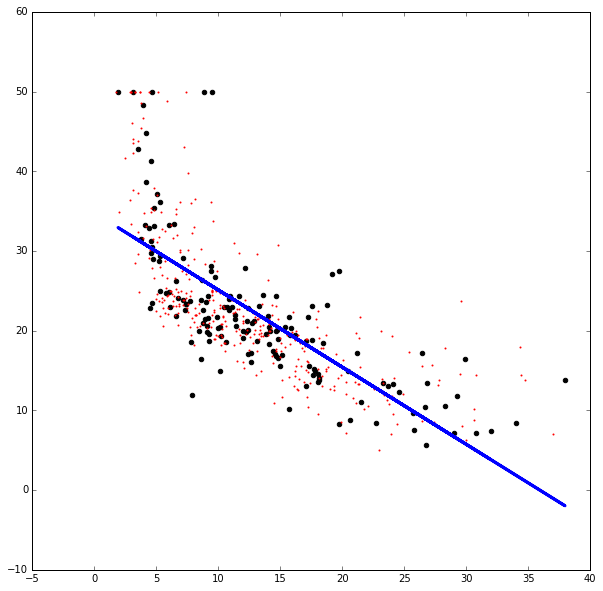

In [ ]:
plt.figure(figsize=(10, 10))

plt.scatter(x_test, y_test, color="black") # Test data
plt.scatter(x_train, y_train, color="red", s=1) # Train data

plt.plot(x_test, model.predict(x_test), color="blue", linewidth=3) # Fitted line

plt.show()

<br>
<br>

#### Practice. 더 좋은 성능을 보이는 Feature 를 찾아보세요!

MSE(Training data) :  37.9339781729
MSE(Test data) :  39.8171505047


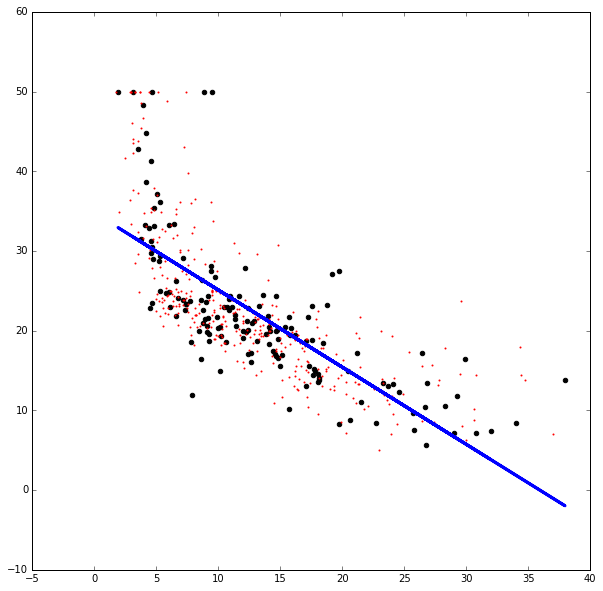

In [ ]:
from sklearn import model_selection, linear_model
from sklearn.metrics import mean_squared_error

# 1. Prepare the data (array!)
boston_data = np.array(df_data)
boston_target = np.array(df_target)

# 2. Feature selection
boston_X = boston_data[:, 12:13] 
boston_Y = boston_target

# 3. Train/Test split
x_train, x_test, y_train, y_test = model_selection.train_test_split(boston_X, boston_Y, test_size=0.3, random_state=0)

# 4. Create model object 
model = linear_model.LinearRegression()

# 5. Train the model 
model.fit(x_train, y_train)

# 6. Test the model
print('MSE(Training data) : ', mean_squared_error(model.predict(x_train), y_train))
print('MSE(Test data) : ', mean_squared_error(model.predict(x_test), y_test))

# 7. Visualize the model
plt.figure(figsize=(10, 10))
plt.scatter(x_test, y_test, color="black") # Test data
plt.scatter(x_train, y_train, color="red", s=1) # Train data
plt.plot(x_test, model.predict(x_test), color="blue", linewidth=3) # Fitted line
plt.show()